In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [5]:
data = pd.read_csv('orders.csv')
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
0,2714054,469662,21386,2015-10-15 08:50:56.000,597982.0,محمود آباد,1.0
1,11104039,3063877,248497,2018-02-11 00:29:26.000,980000.0,خرمدره,1.0
2,4228130,3184893,50144,2016-06-14 00:30:08.000,229358.0,قرچک,1.0
3,22225624,6888562,70208,2018-09-03 14:37:19.000,16514.0,قم,1.0
4,4068771,2533490,67627,2016-05-21 11:51:02.000,133028.0,تهران,1.0


In [6]:
data.shape

(200000, 7)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_Order               200000 non-null  int64  
 1   ID_Customer            200000 non-null  int64  
 2   ID_Item                200000 non-null  int64  
 3   DateTime_CartFinalize  200000 non-null  object 
 4   Amount_Gross_Order     200000 non-null  float64
 5   city_name_fa           200000 non-null  object 
 6   Quantity_item          200000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 10.7+ MB


In [51]:
data_describe = data.filter(['Amount_Gross_Order', 'Quantity_item'])

In [52]:
data_describe.describe()

,Amount_Gross_Order,Quantity_item
count,2.000000e+05,200000.000000
mean,1.458204e+06,1.261225
std,5.450972e+06,1.801186
min,0.000000e+00,1.000000
25%,1.212730e+05,1.000000
50%,3.211010e+05,1.000000
75%,1.011032e+06,1.000000
max,1.530000e+09,500.000000


In [58]:
data_describe.corr()

,Amount_Gross_Order,Quantity_item
Amount_Gross_Order,1.000000,-0.026381
Quantity_item,-0.026381,1.000000


In [8]:
data['DateTime_CartFinalize'] = pd.to_datetime(data['DateTime_CartFinalize'])

In [9]:
data['DayTime_CartFinalize'] = data['DateTime_CartFinalize'].apply(lambda x : dt.datetime(x.year, x.month, x.day))


In [10]:
data.head()

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,DayTime_CartFinalize
0,2714054,469662,21386,2015-10-15 08:50:56,597982.0,محمود آباد,1.0,2015-10-15
1,11104039,3063877,248497,2018-02-11 00:29:26,980000.0,خرمدره,1.0,2018-02-11
2,4228130,3184893,50144,2016-06-14 00:30:08,229358.0,قرچک,1.0,2016-06-14
3,22225624,6888562,70208,2018-09-03 14:37:19,16514.0,قم,1.0,2018-09-03
4,4068771,2533490,67627,2016-05-21 11:51:02,133028.0,تهران,1.0,2016-05-21


In [11]:
LastDay = max(data['DayTime_CartFinalize'])
LastDay

Timestamp('2018-12-11 00:00:00')

In [12]:
min(data['DayTime_CartFinalize'])

Timestamp('2013-09-27 00:00:00')

In [13]:
Recency = data.groupby('ID_Customer')['DayTime_CartFinalize'].apply( lambda x: (LastDay - x.max()).days)
Recency = Recency.reset_index()
Recency.head()

,ID_Customer,DayTime_CartFinalize
0,466132,9
1,466136,445
2,466141,638
3,466146,1024
4,466152,99


In [14]:
Frequency = data.groupby('ID_Customer')['ID_Order'].count()
Frequency = Frequency.reset_index()
Frequency.head()

,ID_Customer,ID_Order
0,466132,11
1,466136,1
2,466141,3
3,466146,1
4,466152,3


In [15]:
RFM1 = pd.merge(Recency, Frequency, on='ID_Customer', how = 'inner' )
RFM1.head()

,ID_Customer,DayTime_CartFinalize,ID_Order
0,466132,9,11
1,466136,445,1
2,466141,638,3
3,466146,1024,1
4,466152,99,3


In [16]:
Monetary = data.groupby('ID_Customer')['Amount_Gross_Order'].sum()
Monetary = Monetary.reset_index()
Monetary.head()

,ID_Customer,Amount_Gross_Order
0,466132,35356058.0
1,466136,306963.0
2,466141,1324312.0
3,466146,302752.0
4,466152,1173027.0


In [17]:
RFM = pd.merge(RFM1, Monetary, on='ID_Customer', how = 'inner' )
RFM.head()

,ID_Customer,DayTime_CartFinalize,ID_Order,Amount_Gross_Order
0,466132,9,11,35356058.0
1,466136,445,1,306963.0
2,466141,638,3,1324312.0
3,466146,1024,1,302752.0
4,466152,99,3,1173027.0


In [18]:
RFM.columns = ['ID_Customer','Recency', 'Frequency', 'Monetary']
RFM.head()

,ID_Customer,Recency,Frequency,Monetary
0,466132,9,11,35356058.0
1,466136,445,1,306963.0
2,466141,638,3,1324312.0
3,466146,1024,1,302752.0
4,466152,99,3,1173027.0


In [19]:
rfm_df = RFM[['Recency', 'Frequency', 'Monetary']]

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,10))
rfm_N = scaler.fit_transform(rfm_df)

In [21]:
rfm_N

array([[1.04260915, 1.60402685, 1.20792806],
       [3.1067859 , 1.        , 1.00180524],
       [4.02051552, 1.12080537, 1.00778824],
       ...,
       [1.91846397, 1.        , 1.00282287],
       [1.87112046, 1.        , 1.00088215],
       [1.91372962, 1.        , 1.00205834]])

In [22]:
rfm_df_scaled = pd.DataFrame(rfm_N)
rfm_df_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,1.042609,1.604027,1.207928
1,3.106786,1.000000,1.001805
2,4.020516,1.120805,1.007788
3,5.847975,1.000000,1.001780
4,1.468701,1.120805,1.006899


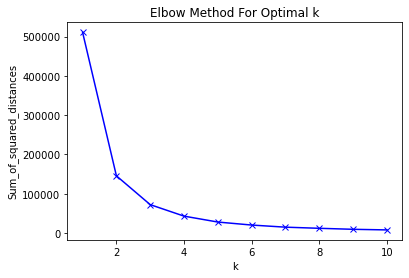

In [23]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rfm_df_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
km = KMeans(n_clusters=6 ,init='k-means++', max_iter=300 )
km = km.fit(rfm_df_scaled)
km

KMeans(n_clusters=6)

In [25]:
km.labels_

array([2, 1, 3, ..., 4, 2, 4])

In [26]:
RFM['Cluster_Id'] = km.labels_
RFM.head()

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
0,466132,9,11,35356058.0,2
1,466136,445,1,306963.0,1
2,466141,638,3,1324312.0,3
3,466146,1024,1,302752.0,0
4,466152,99,3,1173027.0,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

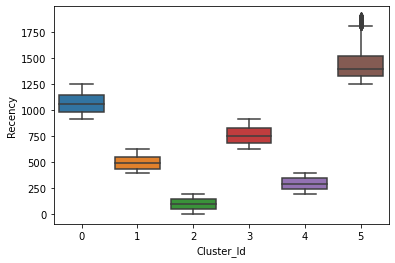

In [27]:
sns.boxplot(x='Cluster_Id', y='Recency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

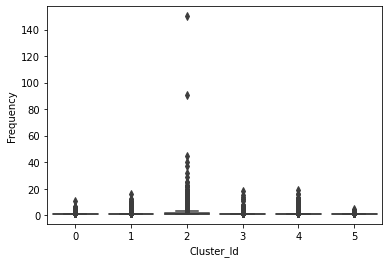

In [28]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=RFM)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Monetary'>

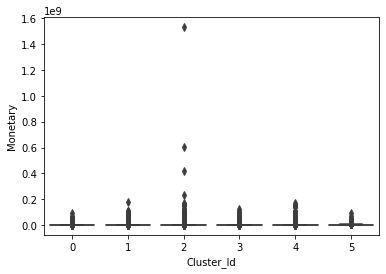

In [29]:
sns.boxplot(x='Cluster_Id', y='Monetary', data=RFM)


In [113]:
RFM[RFM['ID_Customer'] == 466132]

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
0,466132,9,11,35356058.0,2


In [114]:
data[data['ID_Customer'] == 466132]

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,DayTime_CartFinalize
25004,1739614,466132,42545,2015-02-12 18:41:10,29598889.0,تهران,1.0,2015-02-12
39208,10809906,466132,361304,2018-01-24 19:55:43,128440.0,تهران,1.0,2018-01-24
50991,24467239,466132,1523292,2018-11-28 10:27:20,965000.0,تهران,1.0,2018-11-28
55579,24580713,466132,1671385,2018-12-02 14:23:38,206600.0,تهران,1.0,2018-12-02
64206,7946873,466132,369749,2017-07-21 21:59:04,315229.0,تهران,1.0,2017-07-21
91885,24004046,466132,1711488,2018-11-12 19:31:37,45000.0,تهران,1.0,2018-11-12
132207,1074538,466132,5265,2013-12-30 20:05:00,3869057.0,تهران,1.0,2013-12-30
149940,6633327,466132,75068,2017-03-06 18:55:18,119266.0,تهران,1.0,2017-03-06
152773,4909041,466132,80046,2016-09-07 00:33:05,15000.0,تهران,1.0,2016-09-07
177422,24004046,466132,1771143,2018-11-12 19:31:37,24770.0,تهران,2.0,2018-11-12


In [116]:
RFM[RFM['ID_Customer'] == 466146]

,ID_Customer,Recency,Frequency,Monetary,Cluster_Id
3,466146,1024,1,302752.0,0


In [115]:
data[data['ID_Customer'] == 466146]

,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,DayTime_CartFinalize
100995,3470282,466146,46854,2016-02-21 06:41:29,302752.0,خرم آباد,1.0,2016-02-21


In [117]:
RFM.shape

(151634, 5)

In [110]:
RFM[RFM['Cluster_Id'] == 0].shape

(16680, 5)

In [93]:
RFM[RFM['Cluster_Id'] == 1].shape

(26637, 5)

In [94]:
RFM[RFM['Cluster_Id'] == 2].shape

(34018, 5)

In [95]:
RFM[RFM['Cluster_Id'] == 3].shape

(25298, 5)

In [96]:
RFM[RFM['Cluster_Id'] == 4].shape

(40426, 5)

In [97]:
RFM[RFM['Cluster_Id'] == 5].shape

(8575, 5)